In [1]:
# import modules
import math
import numpy as np
import statsmodels.api as sm
import scipy.stats as ss
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# set dimensions of data
n = 100
p = 2

To do:
1. Plot a contour plot of the level sets $\lambda_{max}(X^TX)\vert \vert \beta\vert\vert^2=c$ with heat map to represent gains in efficiency
2. For a fixed beta, Plot a line graph of delta-gain in efficiency against maximum eigenvalue.

These allow us to see how loose our sufficient condition is.
Currently, for EPH versus LL, can only do 2. For WPH versus LL, can do 2. for different sample sizes and show that as sample sizes grow WPH always perform better than LL.

In [3]:
# set the size of the effect
effect_size = 3

# nuisance parameter
rho = 0.5

In [4]:
# generate beta with the desired norm
def generate_beta(p, norm_beta):
    v = np.random.uniform(low=-1, high=1, size=p)
    return v*norm_beta/np.linalg.norm(v)

In [5]:
beta = generate_beta(p, effect_size)

lambda_max = np.log(np.sqrt(5))**2/effect_size**2 # the max eigenvalue of X^TX s.t. L>PO

print(np.linalg.norm(beta)) # check norm = effect_size
print(lambda_max) 
print(np.log(np.sqrt(5))**2)

3.0
0.07195251094389543
0.6475725984950589


In [6]:
print(beta)

[ 2.99894299 -0.07962991]


In [7]:
# generate data matrix X with the desired maximum singular value
def generate_X(n, p, lambda_max):
    U = ss.ortho_group.rvs(n)
    V = ss.ortho_group.rvs(p)
    d = np.random.uniform(low=-1, high=1, size=p-1)*np.sqrt(lambda_max)
    d[::-1].sort()
    singular_values = np.concatenate((np.array([np.sqrt(lambda_max)]), d))
    Sigma = np.concatenate((np.diag(singular_values), np.zeros((n-p, p))), axis=0)
    return U @ Sigma @ V.T

In [8]:
X = generate_X(n, p, lambda_max)
#print(X)

In [9]:
print(np.linalg.eig(X.T@X)[0]) # check eigenvalues of X^TX are as desired

[7.19525109e-02 2.45767554e-06]


In [10]:
eta = X@beta
print(eta)

[ 0.1296321   0.03580741 -0.19357884 -0.01360629  0.00806303  0.02090253
 -0.01562227  0.09290638 -0.12996604 -0.06308618 -0.00073337 -0.07006285
 -0.01183242 -0.05662302 -0.05587652  0.08407501  0.03630814 -0.0466618
 -0.12968091 -0.08103301 -0.03582089  0.04978017  0.04679384 -0.02777821
 -0.11568327  0.12165247 -0.05434775 -0.03964697  0.00135844 -0.01182203
 -0.0449291   0.06639048 -0.01292461  0.04454663 -0.02653223  0.03962123
 -0.02259672  0.06322778  0.01361688 -0.03283615  0.04842967  0.12575414
  0.0626687  -0.06631999 -0.0551721  -0.03333697 -0.02534908  0.02732653
  0.01783216 -0.16605472  0.04949544  0.01346927  0.03937271  0.04354962
 -0.01519474  0.09239148 -0.05836968  0.04090597 -0.10039468  0.07238609
  0.01636313 -0.00558608  0.0581936   0.02797921  0.02607187  0.08990118
 -0.00822989 -0.06294601 -0.04758497 -0.11818978 -0.06977596  0.04083552
 -0.01603392 -0.01060083 -0.08799207 -0.05167738  0.0544899  -0.00736753
  0.02612046 -0.00082218  0.04154469 -0.04454315  0.

In [11]:
# sample continuous survival data using probability integral transform

# find the inverse of the PO cdf
def PO_inv_cdf(u, rho, eta):
    return u/((1-u)*rho*np.exp(eta))

def generate_Y_PO(n, rho, eta):
    y = []
    u = np.random.uniform(size=n) # sample from the standard uniform distribution
    for i in range(n):
        y.append(PO_inv_cdf(u[i], rho, eta[i])) # invert cdf to get samples of random variable Y
    return np.array(y)

In [12]:
Y_PO = generate_Y_PO(n, rho, eta)
#print(Y_PO)

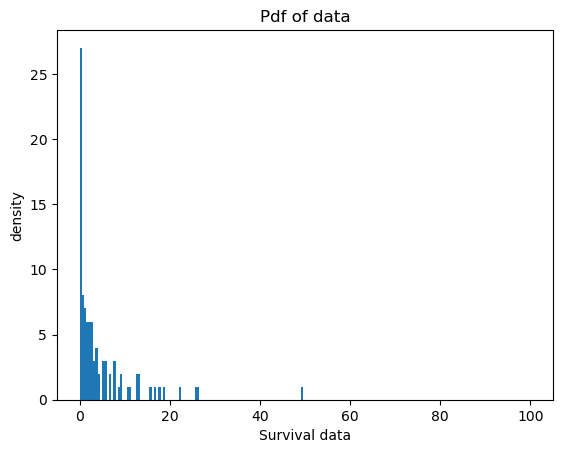

In [13]:
# check that Y_PO follows the distribution assigned by PO

# plot histogram of an entry of Y_PO
def test_Y_PO(n, rho, eta):
    y = []
    u = np.random.uniform(size=n) # sample from the standard uniform distribution
    for i in range(n):
        y.append(PO_inv_cdf(u[i], rho, eta)) # invert cdf to get samples of random variable Y
    return np.array(y)
y_po_test = test_Y_PO(n, rho, eta[0])
plt.hist(y_po_test, bins=200, range=(0,100))
plt.xlabel('Survival data')
plt.ylabel('density')
plt.title('Pdf of data')
plt.show()

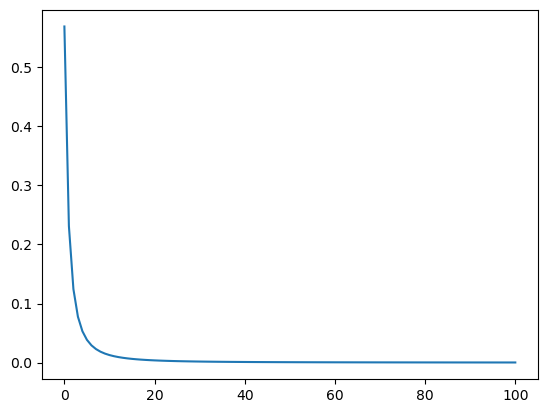

In [14]:
# plot the actual pdf of PO
def PO_pdf(u, rho, eta):
    return rho*np.exp(eta)/(1+rho*np.exp(eta)*u)**2
x_test = [i for i in range(0, 101)]
y_test = [PO_pdf(x, rho, eta[0]) for x in x_test]
plt.plot(x_test,y_test)
plt.show()

In [15]:
# dichotomise survival data
t = 3 # cut off time point
Y_binary = np.array([1 if i <= t else 0 for i in Y_PO]) # dichotomisation
print(t)
#print(Y_binary)

3


In [16]:
# fit logistic model using stats models api
X_1 = np.insert(X, 0, np.ones(n), axis=1)
model1 = sm.Logit(Y_binary, X_1)
result = model1.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.654322
         Iterations 8


In [17]:
beta1 = result.params
print(beta1)
result.summary()

[ 4.40253207e-01 -1.70675959e+03 -1.93315920e+03]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Mon, 02 Jun 2025   Pseudo R-squ.:                 0.02777
Time:                        17:18:29   Log-Likelihood:                -65.432
converged:                       True   LL-Null:                       -67.301
Covariance Type:            nonrobust   LLR p-value:                    0.1543
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4403      0.210      2.098      0.036       0.029       0.852
x1         -1706.7596    920.453     -1.854      0.064   -3510.814      97.294
x2         -1933.1592   1040.785     -1.857      0.063   -3973.061     106.742
==============================================================================
"""

In [18]:
# calculate theoretically what fisher information should be

# for PO model
def Fisher_PO(X):
    return np.linalg.inv(1/3 * X.T@X - 1/(15*n)*X.T@np.ones((n,n))@X)

# for L model
def Fisher_L(X1, beta1):
    eta = X1@beta1
    c = np.exp(eta)/(1+np.exp(eta))**2
    c_vector = c.reshape((n,1))
    W = np.diag(c) - 1/(np.sum(c))*c_vector@c_vector.T
    return np.linalg.inv(X.T@W@X)

In [19]:
beta1_true = np.insert(beta, 0, np.log(rho*t))
print(beta1_true)
F_PO = Fisher_PO(X)
F_L = Fisher_L(X_1, beta1_true)
print(F_PO)
print(F_L)

[ 0.40546511  2.99894299 -0.07962991]
[[535932.38201256 605911.61775264]
 [605911.61775264 685123.38844187]]
[[745834.09713144 843217.73118761]
 [843217.73118761 953448.59605985]]


In [20]:
print(np.sqrt(np.diag(F_L)))

[863.61686941 976.44692434]


In [21]:
eta1 = X_1@beta1_true
c = np.exp(eta1)/(1+np.exp(eta1))**2
c_vector = c.reshape((n,1))
c_max = np.max(c)
c_min = np.min(c)
print(c_min)
print(c_max)
print(c_min**2/(np.sum(c)*c_max))
print(1/(5*n))

0.23292504553964646
0.24721487647802776
0.009148092700535416
0.002


In [22]:
# repeat this process for different values of effect sizes * max evalue & see how much the gain in efficiency changes

# generalise the workflow above
def efficiency_gain_PO1(n, p, rho, effect_size, lambda_max):

    iterations = 100
    # generate beta from effect size
    v = np.random.uniform(low=-1, high=1, size=p)
    beta = v*2/np.linalg.norm(v) # should we randomise?
    eff_gain = np.array([])
    # generate 100 different X's from the required maximum condition number
    for k in range(iterations):
        U = ss.ortho_group.rvs(n)
        V = ss.ortho_group.rvs(p)
        d = np.random.uniform(low=-1, high=1, size=p-1)*np.sqrt(lambda_max)
        d[::-1].sort()
        singular_values = np.concatenate((np.array([np.sqrt(lambda_max)]), d))
        Sigma = np.concatenate((np.diag(singular_values), np.zeros((n-p, p))), axis=0)
        X = U @ Sigma @ V.T

        # find Fisher information of PO model
        Fisher_PO = np.linalg.inv(1/3 * X.T@X - 1/(15*n)*X.T@np.ones((n,n))@X)

        # generate data with the PO model
        eta = X@beta
        def PO_inv_cdf(u, rho, eta):
            return u/((1-u)*rho*np.exp(eta))
        y = []
        u = np.random.uniform(size=n) # sample from the standard uniform distribution
        for i in range(n):
            y.append(PO_inv_cdf(u[i], rho, eta[i]))
        Y = np.array(y)
   
        t = 3 # cut off time point - should we randomise later?
    
        # set up X and beta with intercept
        X_1 = np.insert(X, 0, np.ones(n), axis=1)
        beta1_true = np.insert(beta, 0, np.log(rho*t))
        eta1 = X_1@beta1

        # Find Fisher information of L model
        c = np.exp(eta1)/(1+np.exp(eta1))**2
        c_vector = c.reshape((n,1))
        W = np.diag(c) - 1/(np.sum(c))*c_vector@c_vector.T
        Fisher_L = np.linalg.inv(X.T@W@X)
        np.concatenate((eff_gain, np.diag(Fisher_L - Fisher_PO)))

        # return the vector of efficiency gains
    return 1/iterations*np.sum(eff_gain, axis=0)

In [23]:
# repeat this process for different values of effect sizes * max evalue & see how much the gain in efficiency changes

# generalise the workflow above
def efficiency_gain_PO(n, p, rho, effect_size, lambda_max):

    k = 500
    l = len(effect_size)
    # generate beta from effect size
    effect_size = effect_size.reshape((1,l))
    
    v = np.random.uniform(low=-1, high=1, size=p).reshape((p,1))
    beta = v@effect_size/np.linalg.norm(v) # should we randomise later? currently fixed across k X's # if len(effect_size)=l then p x l
    
    # generate k different X's from the required maximum condition number
    d = np.random.uniform(low=-1, high=1, size=(k,p-1))*np.sqrt(lambda_max) # k x p-1
    d = np.sort(d)[:,::-1]
    U = ss.ortho_group.rvs(n, size=k) # k x n x n
    V = ss.ortho_group.rvs(p, size=k) # k x p x p
    singular_values = np.concatenate((np.array([[np.sqrt(lambda_max) for i in range(k)]]).T, d), axis=1) # k x p
    Sigma = np.concatenate((np.einsum('ji,ki->jik', singular_values, np.eye(p)), np.zeros((k,n-p,p))), axis=1) # k x n x p
        
        
    X = U @ Sigma @ np.transpose(V, axes=(0,2,1)) # k x n x p

        # find Fisher information of PO model
    Fisher_PO = np.linalg.inv(1/3 * np.transpose(X, axes=(0,2,1))@X - 1/(15*n)*np.transpose(X, axes=(0,2,1))@np.ones((k,n,n))@X) # k x p x p
    # extract diagonal
    diag_PO = np.einsum('...ii->...i',Fisher_PO) # k x p
    #print(diag_PO.shape)

        # set up X and beta with intercept
    t = 3 # cut off time point - should we randomise?
    X_1 = np.insert(X, 0, np.ones(n), axis=2) # k x n x p+1
    beta1_true = np.insert(beta, 0, np.log(rho*t), axis=0) # p+1 x l
    eta1 = X_1@beta1_true # k x n x l

        # Find Fisher information of L model
    c = np.exp(eta1)/(1+np.exp(eta1))**2 # k x n x l
    W = np.einsum('...ij,...ik->...jik', c, np.array([np.eye(n,n)])) - 1/(np.sum(c, axis=1).reshape((k,l,1,1)))*np.einsum('dba,dca->dabc', c, c) 
    # k x l x n x n  - k x l @ k x l x n x n = k x l x n x n
    X = X.reshape((k,1,n,p))
    Fisher_L = np.linalg.inv(np.transpose(X, axes=(0,1,3,2))@W@X) # k x p x n @ k x l x n x n @ k x n x p = k x l x p x p - for each of the k X's, there are l effect sizes, 
    # each with a different Fisher L
    # extract diagonal
    diag_L = np.einsum('...ii->...i',Fisher_L) # k x l x p
    #print(diag_L.shape)
    #print(Fisher_L.shape)
    eff_gain = np.array([diag_L[i,:,:]-diag_PO[i,:] for i in range(k)]) # k x l x p
    #print(eff_gain.shape)

        # return the vector of efficiency gains
    return np.median(eff_gain, axis=0)

In [33]:
n=100
max_evalues = np.array([i for i in np.arange(1, 11, 0.2)])
effect_sizes = np.array([i for i in np.arange(1, 21, 0.4)])
size, max_evalue = np.meshgrid(effect_sizes, max_evalues)
level = max_evalue*size**2

efficiency_gain = np.array([efficiency_gain_PO(n, p, rho, effect_sizes, j) for j in max_evalues])

(1000, 100, 2)
Minimum efficiency gain for 0th parameter: 0.4294712969133732
Maximum efficiency gain for 0th parameter: 4738.857710779479


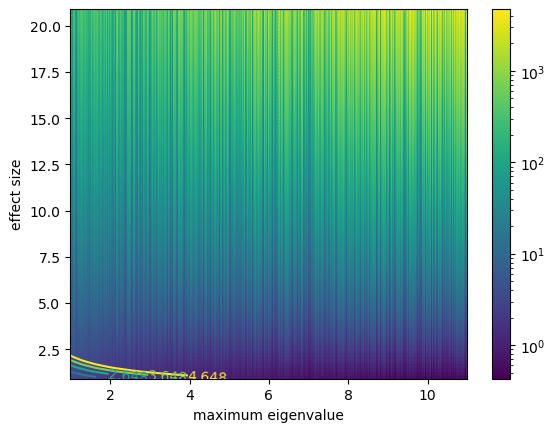

Minimum efficiency gain for 1th parameter: 0.4269406232645232
Maximum efficiency gain for 1th parameter: 4584.487425142103


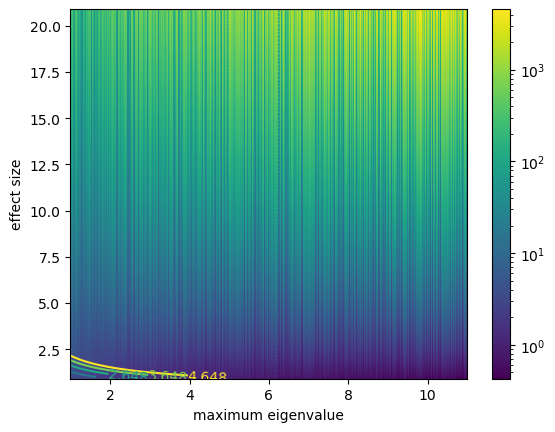

Minimum efficiency gain for 0th parameter: 0.4294712969133732
Maximum efficiency gain for 0th parameter: 4738.857710779479


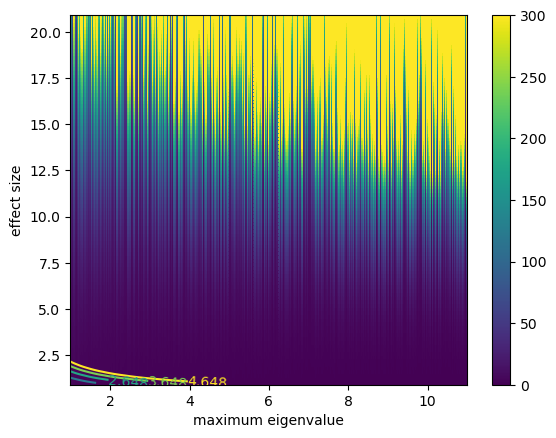

Minimum efficiency gain for 1th parameter: 0.4269406232645232
Maximum efficiency gain for 1th parameter: 4584.487425142103


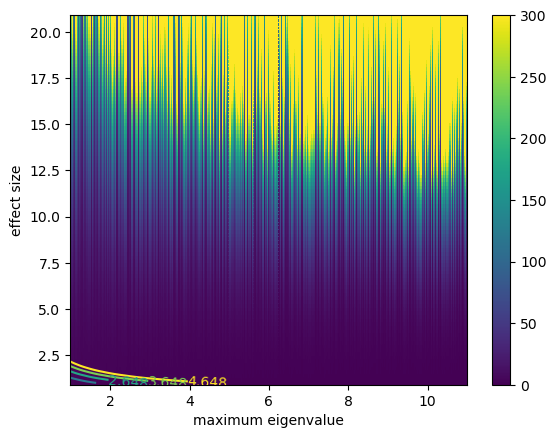

In [ ]:
print(efficiency_gain.shape)
for i in range(p):
    eff_min = np.min(efficiency_gain[:,:,i])
    eff_max = np.max(efficiency_gain[:,:,i])
    print('Minimum efficiency gain for '+str(i)+'th parameter: ' + str(eff_min))
    print('Maximum efficiency gain for '+str(i)+'th parameter: '+str(eff_max))
    fig, ax = plt.subplots()
    CS = ax.contour(max_evalue, size, level, levels=[np.log(np.sqrt(5))**2-x for x in np.arange(1, -5, -1)]) # product of effect size and maximum evalue
    ax.clabel(CS)
    heatmap = ax.pcolor(max_evalue, size, efficiency_gain[:,:,i], norm=matplotlib.colors.LogNorm())
    fig.colorbar(heatmap) 
    
    plt.ylabel('effect size')
    plt.xlabel('maximum eigenvalue')
    plt.show()
for i in range(p):
    eff_min = np.min(efficiency_gain[:,:,i])
    eff_max = np.max(efficiency_gain[:,:,i])
    print('Minimum efficiency gain for '+str(i)+'th parameter: ' + str(eff_min))
    print('Maximum efficiency gain for '+str(i)+'th parameter: '+str(eff_max))
    fig, ax = plt.subplots()
    CS = ax.contour(max_evalue, size, level, levels=[np.log(np.sqrt(5))**2-x for x in np.arange(1, -5, -1)]) # product of effect size and maximum evalue
    ax.clabel(CS)
    heatmap = ax.pcolor(max_evalue, size, efficiency_gain[:,:,i],vmin=0,vmax=300)
    fig.colorbar(heatmap) 
    
    plt.ylabel('effect size')
    plt.xlabel('maximum eigenvalue')    
    plt.show()

In [26]:
delta_eff_gain = efficiency_gain[:,1,:] # fix effect size to 2
print(delta_eff_gain.shape)

(40, 2)


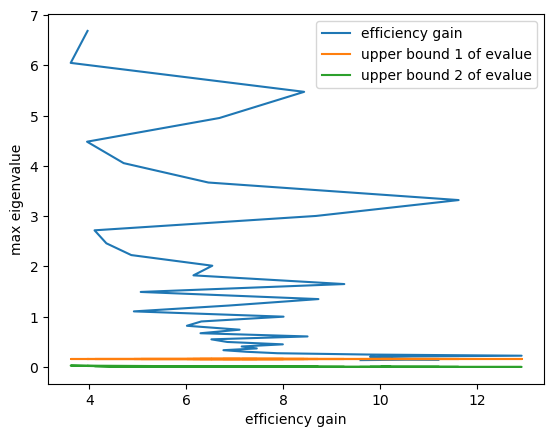

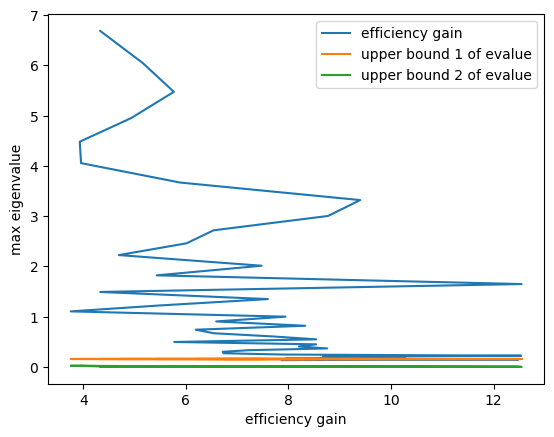

In [27]:
c = [np.log(np.sqrt(5))**2/4 for i in range(len(max_evalues))]

for i in range(p):
    d = [1/j for j in delta_eff_gain[:, i]]
    plt.plot(np.log(delta_eff_gain[:, i]), max_evalues, label='efficiency gain')
    plt.plot(np.log(delta_eff_gain[:, i]), c, label='upper bound 1 of evalue')
    plt.plot(np.log(delta_eff_gain[:, i]), d, label='upper bound 2 of evalue')
    plt.xlabel('efficiency gain')
    plt.ylabel('max eigenvalue')
    plt.legend()
    plt.show()